# 基于MindSpore的广告推荐


## 实验目的

掌握Wide&Deep算法的基本原理以及点击率预测的实验流程。

## 实验环境

ModelArts Notebook环境，硬件平台支持CPU/GPU，具体参考实验正文。



## 推荐系统简介

推荐系统的一个典型场景是广告点击率预估。在我们浏览手机的应用商店时，经常可以看到商店会给我们推荐某些应用，某些推荐的应用往往是广告主通过付费来进行推广。

为了提高广告投放的准确度，广告点击率预估模型需要评价用户点击某些应用的概率，将用户最可能点击的应用进行推送，达到准确的投放广告的目的。一旦我们点击了其中的一个应用，商店就可以成功的向广告投放商进行收费，而广告主们也达到了应用推广的目的。美国著名的电影和电视节目提供商Netflix曾经发起了奖金为百万美元的推荐系统比赛，旨在提升推荐系统的准确度。在广告点击率预估的场景，性能提高了1%的模型往往可以为公司带来巨大的收入。

以APP商店中的推荐系统为例，其整体流程可以如下图所示：

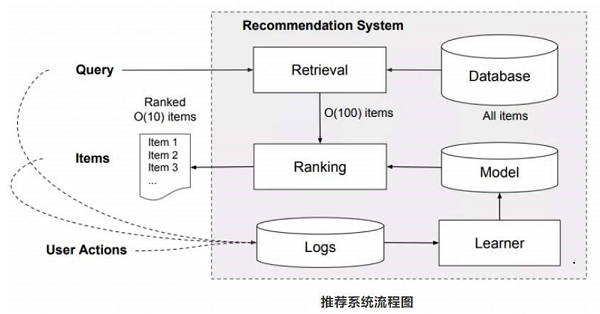

1. 给定一个查询，这个查询可能是用户相关的特征，推荐系统首先会从数据库中检索到查询相关的APP，由于APP的数量非常巨大，因此我们可以取最相关的100个检索结果作为候选APP，这一过程通常叫作粗排。

2. 然后将候选的100个APP送入排序模型中，此处的排序模型就是我们下面将要介绍的Wide&Deep模型，这一过程也被叫作精排。

3. 排序完成后，我们可以将点击概率最高的APP放置于用户最容易注意到的地方。无论用户是否点击了我们的推荐结果，我们都可以构造一个新的日志文件。在累积了一定数量的日志文件后，就可以继续微调排序模型，提高模型的准确程度。



## Wide&Deep模型

Wide&Deep模型是推荐学习与点击预测领域中的经典模型。Wide＆Deep模型共同训练了宽线性模型和深度神经网络，结合了推荐系统的记忆和泛化优势。

### Wide模型

Wide部分是一个线性网络，即y=wx。其设计目的是为了记住数据中特定的特征组合方式。例如广告点击率的场景，购买了电脑主机的用户，点击显示器，键盘等物件广告的概率特别高。因此可以将用户最近是否购买了电脑作为输入模型的输入，也就是特征。假设当前Wide网络只有一个特征，当该特征取1时，y=wx可以得到y=0.9(假设w的值是0.9)，当该特征取0时，y=0。y输出值越大，会增大模型对应用户点击概率的估计。

回到上述APP应用推荐的场景中，可以看到下图的Cross Product Transformation，就是我们的wide部分的输入。Cross Product Transformation是指特征交叉，即将User Installed App和Impression APP进行组合。例如用户手机已经安装了微信，且当前的待估计的APP为QQ，那么这个组合特征就是(User Installed App=’微信’,  Impression APP=’QQ’)。


### Deep模型

Deep部分的设计是为了模型具有较好的泛化能力，在输入的数据没有在训练集中出现时，它依然能够保持相关性较好的输出。

在下图中，Deep模型输入都是一些含义不是非常明显的特征，例如设备类型，用户统计数据等类别特征(Categorical Features)。类别特征一般属于高维特征。例如手机的种类可能存在成千上万个，因此我们通常把这些类别特征通过嵌入(Embedding)的方式，映射成低维空间的参数向量。这个向量可以被认为表示了原先这个类别特征的信息。对于连续特征，其数值本身就具备一定的含义，因此可以直接将其与其他嵌入向量进行拼接。在拼接完成后，可以得到大致为1200维度的向量。将其作为三层全连接层网络的输入，并且选择 ReLU 作为激活函数，其中每层的输出维度分别为 [1024, 512, 256]。

在广告点击率预估的场景中，模型的输出是一个0~1之间的值，表示当前候选APP被点击的概率。因此可以采用逻辑回归函数，将Wide&Deep部分的输出压缩到0~1在之间。首先，Deep部分的输出是一个256维度的向量，可以通过一个线性变换将其映射为维度为1的值，然后和Wide部分的输出进行求和，将求和后的结果输入到逻辑回归函数中。

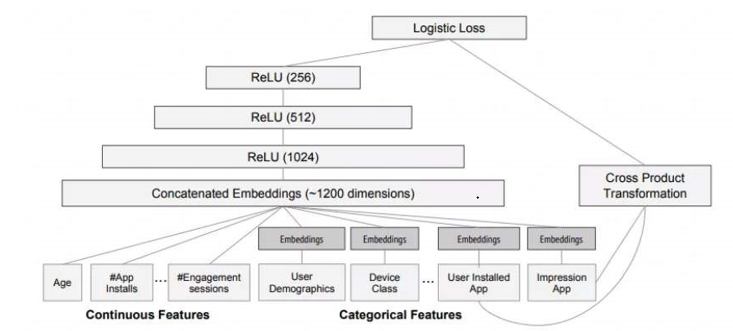


## 实验简介

本实验是基于Criteo的部分数据集对“Wide & Deep Learning for Recommender Systems”论文中Wide&Deep模型的实现。整体过程如下图所示：

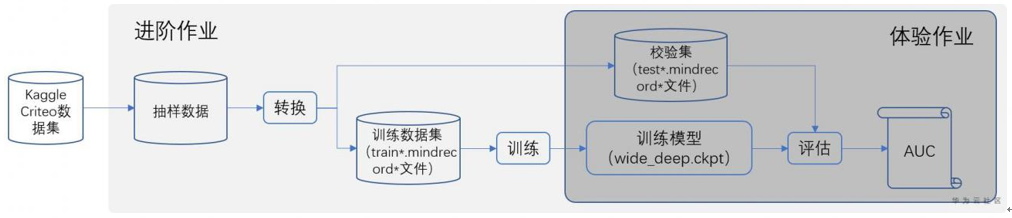


## Criteo数据集

Criteo数据集是Criteo Labs发布的在线广告数据集。 它包含数百万个展示广告的功能值和点击反馈，该数据可作为点击率(CTR)预测的基准。 每个广告都有描述数据的功能。 数据集具有40个属性，第一个属性是标签，其中值1表示已单击广告，而值0表示未单击广告。 该属性包含13个整数列（连续型特征）和26个类别列（类别型），没有提供特征名称，样本按时间排序。该官方数据集包含训练样本4千万，测试样本6百万。官方数据下载链接：https://www.kaggle.com/datasets/mrkmakr/criteo-dataset?resource=download

本实验使用了全量原始数据集的1%，拆分之后的数据集下载链接：https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MachineLearning/data.tar.gz


### 数据处理

在模型定义前，我们需要对数据进行预处理。数据处理的目的是将数据集中的特征取值映射为数值id，并且去除一些出现次数过少的特征值，避免特征值出现次数过少，导致当特征值对应的参数向量的更新次数过少，影响模型的精度。Criteo数据集由13类连续特征和26列类别特征，已经通过哈希方式映射为了32位数值。对应的标签(label)的取值为0和1。

数据处理的核心思路如下图所示，针对类别特征，建立一个词表，里面记录着每次出现的特征取值的编号。然后再遍历每一列的特征取值，将原始的特征值根据词表映射为对应的id。

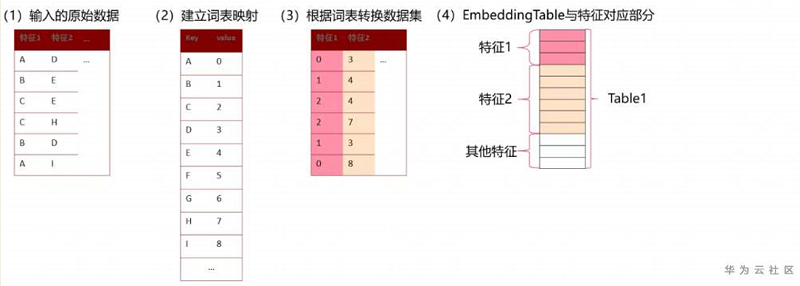

映射操作是为了模型中的嵌入向量查找而准备的。例如，输入数据中的A，B，C被映射为了0,1,2。而0,1,2分别表示在嵌入矩阵中(Embedding Table)的第0行，第1行和第2行。

数据预处理之后本实验会成生成MindRecord格式的数据以便省略数据预处理部分代码。


### MindRecord格式数据下载

使用 `download` 模块对数据集进行下载和解压。数据下载之前需要使用 `pip install download` 安装 `download` 包。


In [1]:
from download import download

url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MachineLearning/data.zip"

download(url, ".", kind="zip", replace=True)

### 数据加载

此处需要将数据加载为MindSpore Dataset格式数据，以便于输入到模型训练，并进行batch等操作。代码如下：


In [2]:
import os
import mindspore.dataset as ds

# 定义数据加载函数
def create_dataset(directory, train_mode=True, batch_size=1000):
    file_prefix_name = 'train_input_part.mindrecord' if train_mode else 'test_input_part.mindrecord'
    file_suffix_name = '00' if train_mode else '0'

    data_set = ds.MindDataset(os.path.join(directory, file_prefix_name + file_suffix_name),
                              columns_list=['feat_ids', 'feat_vals', 'label'],
                              shuffle=train_mode, num_parallel_workers=8)
    data_set = data_set.batch(int(batch_size / 1000), drop_remainder=True)

    operations = [(lambda x, y, z: (np.array(x).flatten().reshape(batch_size, 39),
                   np.array(y).flatten().reshape(batch_size, 39),
                   np.array(z).flatten().reshape(batch_size, 1)))]
    data_set = data_set.map(operations, input_columns=['feat_ids', 'feat_vals', 'label'],
                            num_parallel_workers=8)
    data_set = data_set.project(['feat_ids', 'feat_vals', 'label'])

    return data_set

# 加载训练和验证数据集
data_path = "./data"
batch_size = 16000

ds_train = create_dataset(data_path, train_mode=True, batch_size=batch_size)
ds_eval = create_dataset(data_path, train_mode=False, batch_size=batch_size)

ds_train_size = ds_train.get_dataset_size()
ds_eval_size = ds_eval.get_dataset_size()
print("Train data size: ", ds_train_size)
print("Eval data size: ", ds_eval_size)

Train data size:  25
Eval data size:  3


## 模型构建

本实验需要搭建的是Wide&Deep网络，它由Wide和Deep两个部分组成。

Wide部分是一个线性网络。在实现上，我们将线性网络中的权重视为维度为1，通过嵌入矩阵查找的方式即可获得输入x对应的权重，然后将其和输入的mask相乘，将结果求和。

值得注意的是，我们将连续特征和类别特征进行等同处理，因此这里的mask是为了将连续特征和类别特征进行区而设计的。连续特征mask中的值即为连续特征值，类别特征mask中的值为1。Wide部分的核心代码如下所示，我们定义个名为self.wide_w的权重，它的形状为[词表大小,1]。Deep部分同样有一个嵌入矩阵查找，以及5层的全连接层构成。具体结构见如下代码：


In [3]:
import numpy as np
import mindspore as ms
from mindspore import nn, ops, Parameter
from mindspore.common.initializer import initializer

class DenseLayer(nn.Cell):
    def __init__(self, input_dim, output_dim, use_activation=True):
        super(DenseLayer, self).__init__()
        self.weight = Parameter(initializer("normal", [input_dim, output_dim], ms.float32), name="weight")
        self.bias = Parameter(initializer("normal", [output_dim], ms.float32), name="bias")
        self.act_func = nn.ReLU()
        self.use_activation = use_activation

    def construct(self, x):
        x = x.to(ms.float16)
        weight = self.weight.to(ms.float16)
        bias = self.bias.to(ms.float16)
        wx = ops.matmul(x, weight)
        wx = ops.bias_add(wx, bias)
        if self.use_activation:
            wx = self.act_func(wx)
        wx = wx.to(ms.float32)

        return wx

# 网络主体部分
class WideDeepModel(nn.Cell):
    def __init__(self, batch_size, field_size, vocab_size, emb_dim, deep_layer_dim):
        super(WideDeepModel, self).__init__()
        self.batch_size = batch_size
        self.field_size = field_size
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.all_dim_list = [self.field_size * self.emb_dim] + deep_layer_dim + [1]
        self.wide_b = Parameter(initializer("normal", [1], ms.float32), name='Wide_b')
        self.dense_layer_1 = DenseLayer(self.all_dim_list[0], self.all_dim_list[1])
        self.dense_layer_2 = DenseLayer(self.all_dim_list[1], self.all_dim_list[2])
        self.dense_layer_3 = DenseLayer(self.all_dim_list[2], self.all_dim_list[3])
        self.dense_layer_4 = DenseLayer(self.all_dim_list[3], self.all_dim_list[4])
        self.dense_layer_5 = DenseLayer(self.all_dim_list[4], self.all_dim_list[5], use_activation=False)

        self.deep_embedding = nn.Embedding(self.vocab_size, self.emb_dim)
        self.wide_embedding = nn.Embedding(self.vocab_size, 1)
        self.embedding_table = self.deep_embedding.embedding_table

    def construct(self, id_hldr, wt_hldr):
        wide_id_weight = self.wide_embedding(id_hldr)
        deep_id_embs = self.deep_embedding(id_hldr)
        mask = ops.reshape(wt_hldr, (self.batch_size, self.field_size, 1))
        wx = ops.mul(wide_id_weight, mask)
        wide_out = ops.reshape(wx.sum(axis=1) + self.wide_b, (-1, 1))
        vx = ops.mul(deep_id_embs, mask)
        deep_in = ops.reshape(vx, (-1, self.field_size * self.emb_dim))
        deep_in = self.dense_layer_4(self.dense_layer_3(self.dense_layer_2(self.dense_layer_1(deep_in))))
        deep_out = self.dense_layer_5(deep_in)
        out = wide_out + deep_out
        return out, self.embedding_table

# 模型实例化
field_size = 39
vocab_size = 200000
emb_dim = 80
deep_layer_dim = [1024, 512, 256, 128]  # 深度网络的维数
WideDeep_net = WideDeepModel(batch_size, field_size, vocab_size, emb_dim, deep_layer_dim)


## 损失函数及优化器

我们采用交叉熵作为损失函数，Wide部分采用FTRL作为优化器。FTRL可以产生较好的稀疏权重，可以帮助筛选有价值的特征，并且可以压缩模型权重。Deep采用Adam优化器。

In [4]:
from mindspore import ParameterTuple

l2_coef = 8e-5
loss = ops.SigmoidCrossEntropyWithLogits()

# 将权重分开
trainable_params = WideDeep_net.trainable_params()
weights_w = []
weights_d = []
for params in trainable_params:
    if 'wide' in params.name:
        weights_w.append(params)
    else:
        weights_d.append(params)

weights_w = ParameterTuple(weights_w)
weights_d = ParameterTuple(weights_d)

optimizer_d = nn.Adam(params=weights_d, learning_rate=3.5e-4, eps=1e-8)
optimizer_w = nn.FTRL(params=weights_w, learning_rate=5e-2, l1=1e-8, l2=1e-8, initial_accum=1.0)


## 前向计算

搭建模型前向计算损失的过程，这里Wide模型和Deep模型分开计算损失，过程如下代码：

In [5]:
def forward_w(data):
    predict, _ = WideDeep_net(data['feat_ids'], data['feat_vals'])
    log_loss = loss(predict, data['label'])  # Tensor:(16000, 1)
    wide_loss = ops.mean(log_loss)
    return wide_loss

def forward_d(data):
    predict, embedding_table = WideDeep_net(data['feat_ids'], data['feat_vals'])
    log_loss = loss(predict, data['label'])  # Tensor:(16000, 1)
    l2_loss_v = ((ops.square(embedding_table)).sum()) / 2
    deep_loss = ops.mean(log_loss) + l2_coef * l2_loss_v
    return deep_loss

## 模型训练

根据分开的前向过程计算的不同的loss来分别计算梯度，然后反向传播更新模型参数，详情见如下代码：

In [6]:
import time

# 根据训练参数和前向计算过程初始化求导函数用于计算梯度
grad_w = ms.value_and_grad(forward_w, None, weights_w)
grad_d = ms.value_and_grad(forward_d, None, weights_d)

epochs = 20
for epoch in range(epochs):
    losses_w = []
    losses_d = []
    for step, data in enumerate(ds_train.create_dict_iterator()):
        begin_time = time.time()
        loss_w, grads_w = grad_w(data)
        loss_d, grads_d = grad_d(data)

        optimizer_w(grads_w)
        optimizer_d(grads_d)

        losses_w.append(loss_w.asnumpy())
        losses_d.append(loss_d.asnumpy())

        end_time = time.time()
        times = end_time - begin_time
        print(f"Epoch:[{(epoch + 1):>3d}/{epochs :>3d}], "
              f"step:[{step:>4d}/{ds_train_size:>4d}], "
              f"loss_w:{loss_w.asnumpy():.4f} , "
              f"loss_d:{loss_d.asnumpy():.4f} , "
              f"time:{times:.2f}s")
    if (epoch+1) > 10:
        ms.save_checkpoint(WideDeep_net, f"./WideDeep_net_{epoch + 1}.ckpt")
    print(f"Epoch:{(epoch + 1):>3d},"
          f"Mean loss_w:{np.mean(losses_w):.4f} ,"
          f"Mean loss_d:{np.mean(losses_d):.4f}")



Epoch:[  1/ 20], step:[   0/  25], loss_w:0.6945 , loss_d:0.7584 , time:2.76s
Epoch:[  1/ 20], step:[   1/  25], loss_w:0.6750 , loss_d:0.7365 , time:0.22s
Epoch:[  1/ 20], step:[   2/  25], loss_w:0.6586 , loss_d:0.7174 , time:0.09s
Epoch:[  1/ 20], step:[   3/  25], loss_w:0.6466 , loss_d:0.7027 , time:0.09s
Epoch:[  1/ 20], step:[   4/  25], loss_w:0.6355 , loss_d:0.6890 , time:0.09s
Epoch:[  1/ 20], step:[   5/  25], loss_w:0.6283 , loss_d:0.6792 , time:0.09s
...
Epoch:[ 20/ 20], step:[  20/  25], loss_w:0.4827 , loss_d:0.4863 , time:0.09s
Epoch:[ 20/ 20], step:[  21/  25], loss_w:0.5218 , loss_d:0.5254 , time:0.10s
Epoch:[ 20/ 20], step:[  22/  25], loss_w:0.4963 , loss_d:0.5000 , time:0.10s
Epoch:[ 20/ 20], step:[  23/  25], loss_w:0.4781 , loss_d:0.4818 , time:0.10s
Epoch:[ 20/ 20], step:[  24/  25], loss_w:0.5020 , loss_d:0.5058 , time:0.10s
Epoch: 20,Mean loss_w:0.4947 ,Mean loss_d:0.4982


## 模型验证

使用前面生成的用于验证的数据集，做模型的前向推理，然后通过评价指标得出结果。这里使用AUC作为评价指标，AUC（Area Under Curve）为ROC曲线下与坐标轴围成的面积，数值在0到1之间，越接近1说明模型效果越好，反之则越差。具体代码如下：

In [7]:
from sklearn.metrics import roc_auc_score


def AUCMetric(predict, label):
    all_predict = predict.asnumpy().flatten().tolist()  # predict
    all_label = label.asnumpy().flatten().tolist()  # label
    if len(all_predict) != len(all_label):
        raise RuntimeError('true_labels.size is not equal to pred_probs.size()')
    auc = roc_auc_score(all_label, all_predict)
    return auc

# 模型验证
test_ckpt = './data/wide_deep.ckpt'

parameter = ms.load_checkpoint(test_ckpt)
ms.load_param_into_net(WideDeep_net, parameter)
aucs = []
for step, data in enumerate(ds_eval.create_dict_iterator()):
    begin_time = time.time()
    logits, _ = WideDeep_net(data['feat_ids'], data['feat_vals'])
    pred_probs = ops.sigmoid(logits)

    auc = AUCMetric(pred_probs, data['label'])
    end_time = time.time()
    times = end_time - begin_time
    aucs.append(auc)

    print(f"step:[{step:>3d}/{ds_eval_size:>3d}], "
          f"time:{times:.3f}s,"
          f"auc:{auc :.4f}")
print(f"Mean auc: {np.mean(aucs) :.4f}")
print("Eval over!")

step:[  0/  3], time:0.516s,auc:0.7594
step:[  1/  3], time:0.170s,auc:0.7607
step:[  2/  3], time:0.034s,auc:0.7562
Mean auc: 0.7588
Eval over!
